In [1]:
import os, torch, math, json, random, ast, time

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import torchvision.transforms.functional as FT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from torch.utils.data.dataloader import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchsummary import summary
from PIL import Image
from typing import List, Dict, Tuple

In [39]:
# check for gpu
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(torch.cuda.device_count())
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))
device

2
True
0
NVIDIA GeForce RTX 3060


device(type='cuda', index=1)

# Explore Sample of Data

In [3]:
DATA_DIR = "/home/jaero/interviews/aws/vector_search/data/"
GEO_DATA_DIR = os.path.join(DATA_DIR, "geological_similarity")
classes = sorted([c for c in os.listdir(GEO_DATA_DIR) if c != ".DS_Store"])
classes

['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist']

In [4]:
def read_image_as_np_array(fpath: str) -> np.ndarray:
    """Utility function to read in image file as numpy array

    Args:
        fpath (str): file path to image

    Returns:
        np.ndarray: image returned as numpy array
    """
    with Image.open(fpath) as im:
        arr = np.asarray(im.convert('RGB'))
    return arr


In [5]:
sample_file = os.path.join(GEO_DATA_DIR, "gneiss/0A3V2.jpg")
arr = read_image_as_np_array(sample_file)
print(arr.shape)
Image.open(sample_file)

(28, 28, 3)


Notes: 
- Dimensions of image are very small
- low resolution may make it difficult to retrieve features from to distinguish from other images


/home/jaero/interviews/aws/vector_search/data/geological_similarity/andesite/8PDOC.jpg
	andesite - Before Upsampling:  (28, 28, 3)
	andesite - After Upsampling:  torch.Size([112, 112, 3])

/home/jaero/interviews/aws/vector_search/data/geological_similarity/gneiss/AORV0.jpg
	gneiss - Before Upsampling:  (28, 28, 3)
	gneiss - After Upsampling:  torch.Size([112, 112, 3])

/home/jaero/interviews/aws/vector_search/data/geological_similarity/marble/C9YSJ.jpg
	marble - Before Upsampling:  (28, 28, 3)
	marble - After Upsampling:  torch.Size([112, 112, 3])

/home/jaero/interviews/aws/vector_search/data/geological_similarity/quartzite/GQ4S6.jpg
	quartzite - Before Upsampling:  (28, 28, 3)
	quartzite - After Upsampling:  torch.Size([112, 112, 3])

/home/jaero/interviews/aws/vector_search/data/geological_similarity/rhyolite/WIVQW.jpg
	rhyolite - Before Upsampling:  (28, 28, 3)
	rhyolite - After Upsampling:  torch.Size([112, 112, 3])

/home/jaero/interviews/aws/vector_search/data/geological_simila

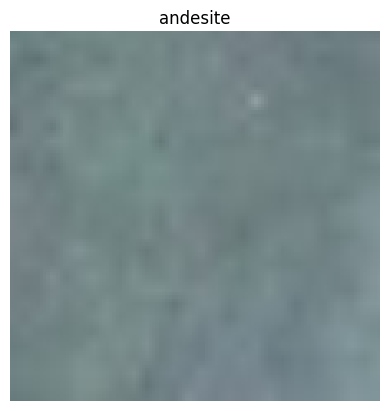

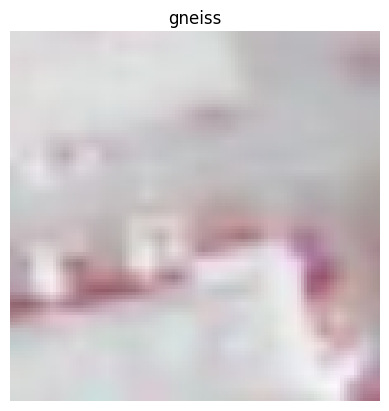

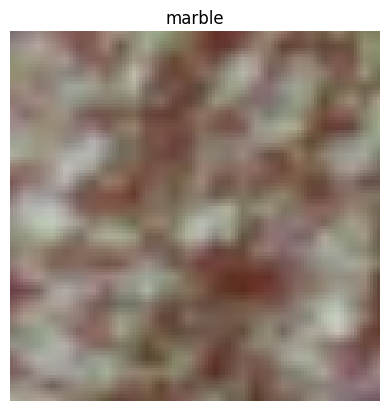

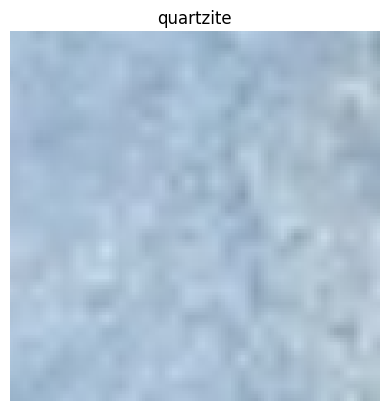

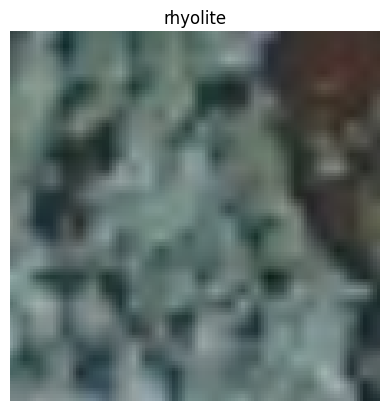

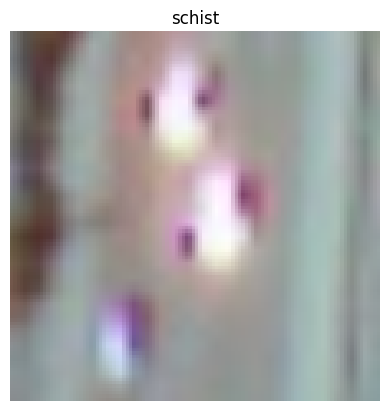

In [6]:
# showcase an example of each class
# use some basic upsampling for visualization purposes
import random

image_dict = {}
for c in classes:
    dirpath = os.path.join(GEO_DATA_DIR, c)
    sample_path = os.path.join(dirpath, os.listdir(dirpath)[random.randint(0, len(os.listdir(dirpath)))])
    arr = read_image_as_np_array(sample_path)
    print(f"\n{sample_path}")
    print(f"\t{c} - Before Upsampling: ", arr.shape)
    tensor = torch.tensor(arr).unsqueeze(0).permute(0,3,1,2)
    upsample_layer = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
    tensor = upsample_layer(tensor)
    tensor = tensor.squeeze(0).permute(1,2,0)
    print(f"\t{c} - After Upsampling: ", tensor.shape)
    img = Image.fromarray(tensor.detach().cpu().numpy())
    image_dict[c] = img


for c, img in image_dict.items():
    plt.figure()
    plt.imshow(img)
    plt.title(c)
    plt.axis('off')


    

Notes
- upsampling to 56x56 helps to visualize images, but apart from color and some dense pixel areas the clarity and edge feautures are a bit obscure

# Metadata of Provided Dataset

In [7]:
metadata = []
for c in classes:
    sizes = set()
    count = 0
    for root, dirs, files in os.walk(os.path.join(GEO_DATA_DIR, c)):
        for file in files:
            fpath = os.path.join(root, file)
            arr = read_image_as_np_array(fpath)
            shape = arr.shape
            sizes.add(shape)
            count += 1 
    metadata.append({'class': c, 'sizes': [s for s in sizes], 'count': count})

df = pd.DataFrame(metadata)
df

,class,sizes,count
0,andesite,"[(28, 28, 3)]",5000
1,gneiss,"[(28, 28, 3)]",5000
2,marble,"[(28, 28, 3)]",4998
3,quartzite,"[(28, 28, 3)]",5000
4,rhyolite,"[(28, 28, 3)]",5000
5,schist,"[(28, 28, 3)]",5000


Notes: 
- consistent image sizes
- class distribution seem to be fairly balanced

## Attempt Super Resolution Using Pretrained Model ESRGAN
- Source Attribution: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Super-Resolution


In [8]:
"""
The following code in this block was taken from: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Super-Resolution
in order to initialize a pretrained Super Resolution Model for input image augmentation

License: MIT License
"""

# Constants
rgb_weights = torch.FloatTensor([65.481, 128.553, 24.966]).to(device)
imagenet_mean = torch.FloatTensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(2)
imagenet_std = torch.FloatTensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(2)
imagenet_mean_cuda = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)
imagenet_std_cuda = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)


class ConvolutionalBlock(nn.Module):
    """
    A convolutional block, comprising convolutional, BN, activation layers.
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, batch_norm=False, activation=None):
        """
        :param in_channels: number of input channels
        :param out_channels: number of output channe;s
        :param kernel_size: kernel size
        :param stride: stride
        :param batch_norm: include a BN layer?
        :param activation: Type of activation; None if none
        """
        super(ConvolutionalBlock, self).__init__()

        if activation is not None:
            activation = activation.lower()
            assert activation in {'prelu', 'leakyrelu', 'tanh'}

        # A container that will hold the layers in this convolutional block
        layers = list()

        # A convolutional layer
        layers.append(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2))

        # A batch normalization (BN) layer, if wanted
        if batch_norm is True:
            layers.append(nn.BatchNorm2d(num_features=out_channels))

        # An activation layer, if wanted
        if activation == 'prelu':
            layers.append(nn.PReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU(0.2))
        elif activation == 'tanh':
            layers.append(nn.Tanh())

        # Put together the convolutional block as a sequence of the layers in this container
        self.conv_block = nn.Sequential(*layers)

    def forward(self, input):
        """
        Forward propagation.

        :param input: input images, a tensor of size (N, in_channels, w, h)
        :return: output images, a tensor of size (N, out_channels, w, h)
        """
        output = self.conv_block(input)  # (N, out_channels, w, h)

        return output


class SubPixelConvolutionalBlock(nn.Module):
    """
    A subpixel convolutional block, comprising convolutional, pixel-shuffle, and PReLU activation layers.
    """
    def __init__(self, kernel_size=3, n_channels=64, scaling_factor=2):
        """
        :param kernel_size: kernel size of the convolution
        :param n_channels: number of input and output channels
        :param scaling_factor: factor to scale input images by (along both dimensions)
        """
        super(SubPixelConvolutionalBlock, self).__init__()

        # A convolutional layer that increases the number of channels by scaling factor^2, followed by pixel shuffle and PReLU
        self.conv = nn.Conv2d(in_channels=n_channels, out_channels=n_channels * (scaling_factor ** 2),
                              kernel_size=kernel_size, padding=kernel_size // 2)
        # These additional channels are shuffled to form additional pixels, upscaling each dimension by the scaling factor
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=scaling_factor)
        self.prelu = nn.PReLU()

    def forward(self, input):
        """
        Forward propagation.

        :param input: input images, a tensor of size (N, n_channels, w, h)
        :return: scaled output images, a tensor of size (N, n_channels, w * scaling factor, h * scaling factor)
        """
        output = self.conv(input)  # (N, n_channels * scaling factor^2, w, h)
        output = self.pixel_shuffle(output)  # (N, n_channels, w * scaling factor, h * scaling factor)
        output = self.prelu(output)  # (N, n_channels, w * scaling factor, h * scaling factor)

        return output


class ResidualBlock(nn.Module):
    """
    A residual block, comprising two convolutional blocks with a residual connection across them.
    """
    def __init__(self, kernel_size=3, n_channels=64):
        """
        :param kernel_size: kernel size
        :param n_channels: number of input and output channels (same because the input must be added to the output)
        """
        super(ResidualBlock, self).__init__()

        # The first convolutional block
        self.conv_block1 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=True, activation='PReLu')

        # The second convolutional block
        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=True, activation=None)

    def forward(self, input):
        """
        Forward propagation.

        :param input: input images, a tensor of size (N, n_channels, w, h)
        :return: output images, a tensor of size (N, n_channels, w, h)
        """
        residual = input  # (N, n_channels, w, h)
        output = self.conv_block1(input)  # (N, n_channels, w, h)
        output = self.conv_block2(output)  # (N, n_channels, w, h)
        output = output + residual  # (N, n_channels, w, h)

        return output


class SRResNet(nn.Module):
    """
    The SRResNet, as defined in the paper.
    """
    def __init__(self, large_kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16, scaling_factor=4):
        """
        :param large_kernel_size: kernel size of the first and last convolutions which transform the inputs and outputs
        :param small_kernel_size: kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
        :param n_channels: number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
        :param n_blocks: number of residual blocks
        :param scaling_factor: factor to scale input images by (along both dimensions) in the subpixel convolutional block
        """
        super(SRResNet, self).__init__()

        # Scaling factor must be 2, 4, or 8
        scaling_factor = int(scaling_factor)
        assert scaling_factor in {2, 4, 8}, "The scaling factor must be 2, 4, or 8!"

        # The first convolutional block
        self.conv_block1 = ConvolutionalBlock(in_channels=3, out_channels=n_channels, kernel_size=large_kernel_size,
                                              batch_norm=False, activation='PReLu')

        # A sequence of n_blocks residual blocks, each containing a skip-connection across the block
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(kernel_size=small_kernel_size, n_channels=n_channels) for i in range(n_blocks)])

        # Another convolutional block
        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels,
                                              kernel_size=small_kernel_size,
                                              batch_norm=True, activation=None)

        # Upscaling is done by sub-pixel convolution, with each such block upscaling by a factor of 2
        n_subpixel_convolution_blocks = int(math.log2(scaling_factor))
        self.subpixel_convolutional_blocks = nn.Sequential(
            *[SubPixelConvolutionalBlock(kernel_size=small_kernel_size, n_channels=n_channels, scaling_factor=2) for i
              in range(n_subpixel_convolution_blocks)])

        # The last convolutional block
        self.conv_block3 = ConvolutionalBlock(in_channels=n_channels, out_channels=3, kernel_size=large_kernel_size,
                                              batch_norm=False, activation='Tanh')

    def forward(self, lr_imgs):
        """
        Forward prop.

        :param lr_imgs: low-resolution input images, a tensor of size (N, 3, w, h)
        :return: super-resolution output images, a tensor of size (N, 3, w * scaling factor, h * scaling factor)
        """
        output = self.conv_block1(lr_imgs)  # (N, 3, w, h)
        residual = output  # (N, n_channels, w, h)
        output = self.residual_blocks(output)  # (N, n_channels, w, h)
        output = self.conv_block2(output)  # (N, n_channels, w, h)
        output = output + residual  # (N, n_channels, w, h)
        output = self.subpixel_convolutional_blocks(output)  # (N, n_channels, w * scaling factor, h * scaling factor)
        sr_imgs = self.conv_block3(output)  # (N, 3, w * scaling factor, h * scaling factor)

        return sr_imgs


class Generator(nn.Module):
    """
    The generator in the SRGAN, as defined in the paper. Architecture identical to the SRResNet.
    """
    def __init__(self, large_kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16, scaling_factor=4):
        """
        :param large_kernel_size: kernel size of the first and last convolutions which transform the inputs and outputs
        :param small_kernel_size: kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
        :param n_channels: number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
        :param n_blocks: number of residual blocks
        :param scaling_factor: factor to scale input images by (along both dimensions) in the subpixel convolutional block
        """
        super(Generator, self).__init__()

        # The generator is simply an SRResNet, as above
        self.net = SRResNet(large_kernel_size=large_kernel_size, small_kernel_size=small_kernel_size,
                            n_channels=n_channels, n_blocks=n_blocks, scaling_factor=scaling_factor)

    def initialize_with_srresnet(self, srresnet_checkpoint):
        """
        Initialize with weights from a trained SRResNet.

        :param srresnet_checkpoint: checkpoint filepath
        """
        srresnet = torch.load(srresnet_checkpoint)['model']
        self.net.load_state_dict(srresnet.state_dict())

        print("\nLoaded weights from pre-trained SRResNet.\n")

    def forward(self, lr_imgs):
        """
        Forward prop.

        :param lr_imgs: low-resolution input images, a tensor of size (N, 3, w, h)
        :return: super-resolution output images, a tensor of size (N, 3, w * scaling factor, h * scaling factor)
        """
        sr_imgs = self.net(lr_imgs)  # (N, n_channels, w * scaling factor, h * scaling factor)

        return sr_imgs


## Utility Classes/Functions

def convert_image(img, source, target):
    """
    Convert an image from a source format to a target format.

    :param img: image
    :param source: source format, one of 'pil' (PIL image), '[0, 1]' or '[-1, 1]' (pixel value ranges)
    :param target: target format, one of 'pil' (PIL image), '[0, 255]', '[0, 1]', '[-1, 1]' (pixel value ranges),
                   'imagenet-norm' (pixel values standardized by imagenet mean and std.),
                   'y-channel' (luminance channel Y in the YCbCr color format, used to calculate PSNR and SSIM)
    :return: converted image
    """
    assert source in {'pil', '[0, 1]', '[-1, 1]'}, "Cannot convert from source format %s!" % source
    assert target in {'pil', '[0, 255]', '[0, 1]', '[-1, 1]', 'imagenet-norm',
                      'y-channel'}, "Cannot convert to target format %s!" % target

    # Convert from source to [0, 1]
    if source == 'pil':
        img = FT.to_tensor(img)

    elif source == '[0, 1]':
        pass  # already in [0, 1]

    elif source == '[-1, 1]':
        img = (img + 1.) / 2.

    # Convert from [0, 1] to target
    if target == 'pil':
        img = FT.to_pil_image(img)

    elif target == '[0, 255]':
        img = 255. * img

    elif target == '[0, 1]':
        pass  # already in [0, 1]

    elif target == '[-1, 1]':
        img = 2. * img - 1.

    elif target == 'imagenet-norm':
        if img.ndimension() == 3:
            img = (img - imagenet_mean) / imagenet_std
        elif img.ndimension() == 4:
            img = (img - imagenet_mean_cuda) / imagenet_std_cuda

    elif target == 'y-channel':
        # Based on definitions at https://github.com/xinntao/BasicSR/wiki/Color-conversion-in-SR
        # torch.dot() does not work the same way as numpy.dot()
        # So, use torch.matmul() to find the dot product between the last dimension of an 4-D tensor and a 1-D tensor
        img = torch.matmul(255. * img.permute(0, 2, 3, 1)[:, 4:-4, 4:-4, :], rgb_weights) / 255. + 16.

    return img

In [9]:
# Load models
srresnet = SRResNet()
srgan_generator = Generator()

# Model checkpoints
srgan_checkpoint = "../saved_models/checkpoint_srgan.pth.tar"
srresnet_checkpoint = "../saved_models/checkpoint_srresnet.pth.tar"

# Load models
srresnet.load_state_dict(torch.load(srresnet_checkpoint,  weights_only=True))
srgan_generator.load_state_dict(torch.load(srgan_checkpoint,  weights_only=True))

srresnet.to(device)
srgan_generator.to(device)

srresnet.eval()
srgan_generator.eval()

def super_res_transform(img: Image.Image, srgan_generator, device = "cpu") -> Image.Image:
    srgan_generator.to(device)
    # Super-resolution (SR) with SRGAN
    tensor = convert_image(img, source='pil', target='imagenet-norm').unsqueeze(0)
    tensor = srgan_generator(tensor.to(device))
    tensor = tensor.squeeze(0).cpu().detach()
    img = convert_image(tensor, source='[-1, 1]', target='pil')
    img = img.convert('RGB')
    return img


def test_super_res(img_path):
    lr_img = Image.open(img_path).convert('RGB')
    bicubic_img  = lr_img.resize((112, 112), Image.BICUBIC)
    hr_img = bicubic_img

    # Super-resolution (SR) with SRResNet
    sr_img_srresnet = srresnet(convert_image(lr_img, source='pil', target='imagenet-norm').unsqueeze(0).to(device))
    sr_img_srresnet = sr_img_srresnet.squeeze(0).cpu().detach()
    sr_img_srresnet = convert_image(sr_img_srresnet, source='[-1, 1]', target='pil')

    sr_img_srgan = super_res_transform(lr_img, srgan_generator, device=device)

    return lr_img, bicubic_img, sr_img_srresnet, sr_img_srgan

/home/jaero/interviews/aws/vector_search/data/geological_similarity/andesite/JJ2VO.jpg
	Super Res Dimensions: (112, 112)
/home/jaero/interviews/aws/vector_search/data/geological_similarity/gneiss/NX4J1.jpg
	Super Res Dimensions: (112, 112)
/home/jaero/interviews/aws/vector_search/data/geological_similarity/marble/PQMPR.jpg
	Super Res Dimensions: (112, 112)
/home/jaero/interviews/aws/vector_search/data/geological_similarity/quartzite/QVI1N.jpg
	Super Res Dimensions: (112, 112)
/home/jaero/interviews/aws/vector_search/data/geological_similarity/rhyolite/C4K1V.jpg
	Super Res Dimensions: (112, 112)
/home/jaero/interviews/aws/vector_search/data/geological_similarity/schist/ZWXDO.jpg
	Super Res Dimensions: (112, 112)


/tmp/ipykernel_63974/1710353438.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


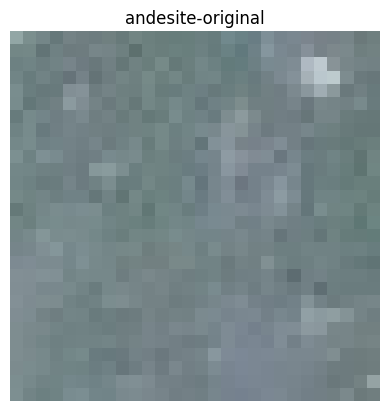

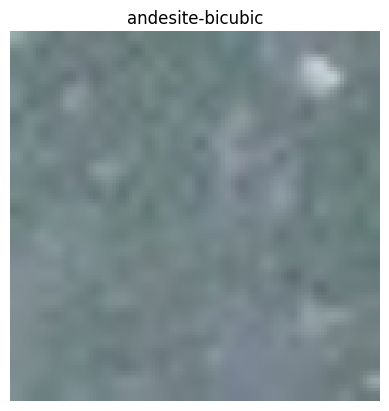

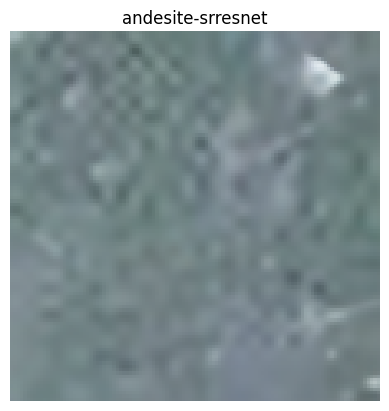

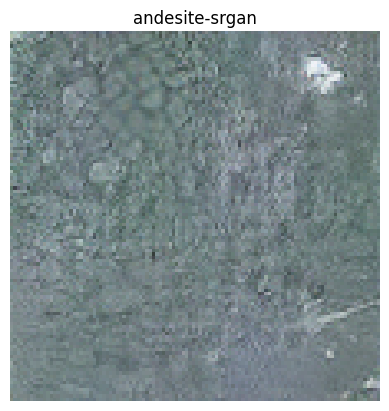

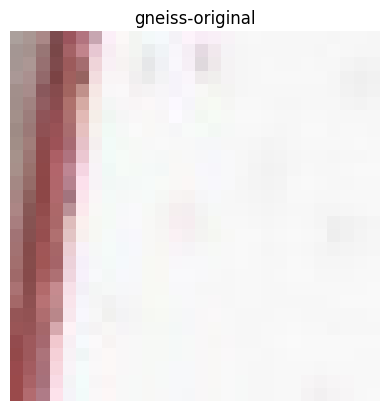

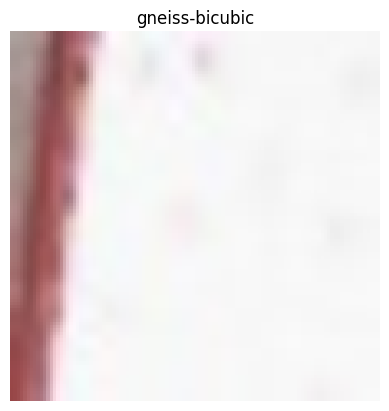

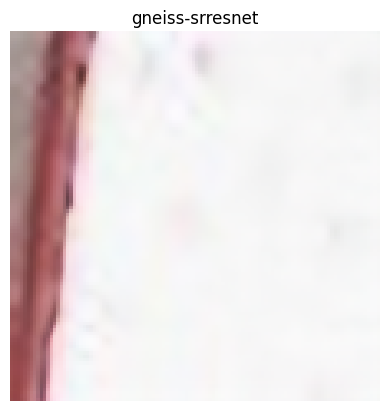

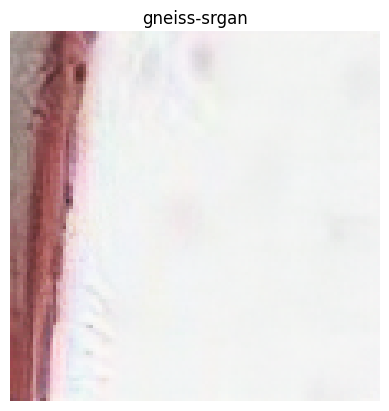

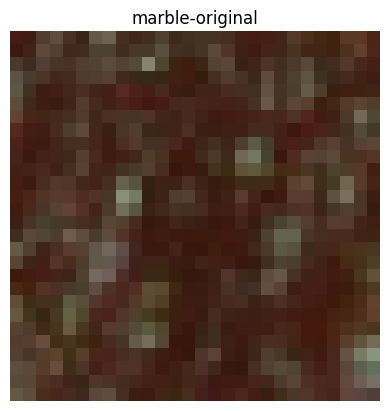

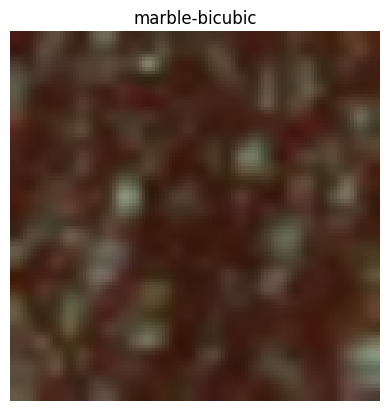

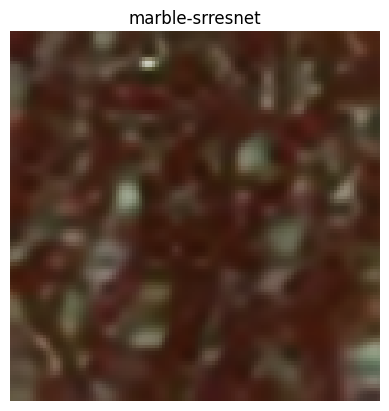

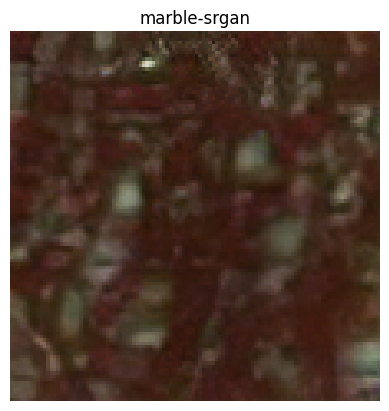

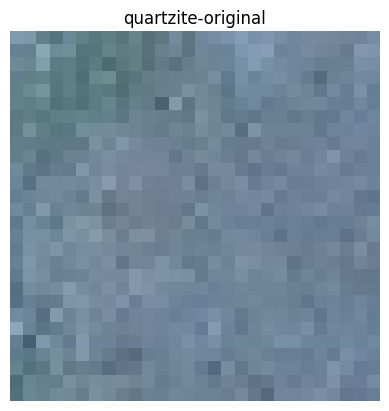

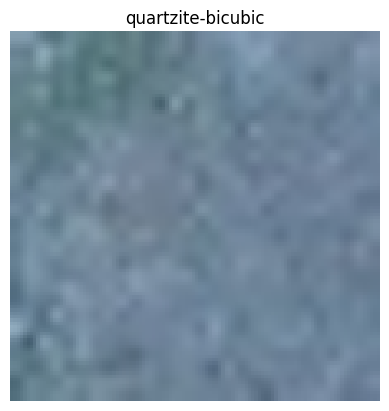

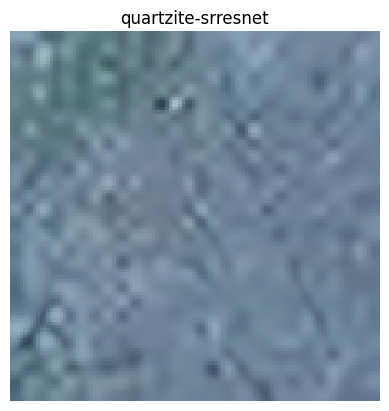

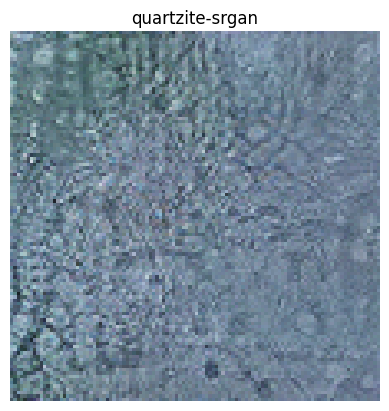

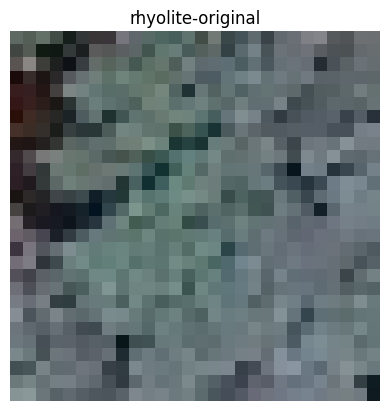

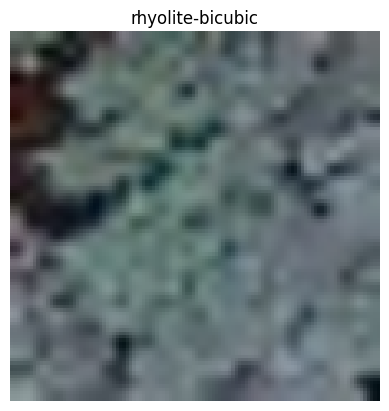

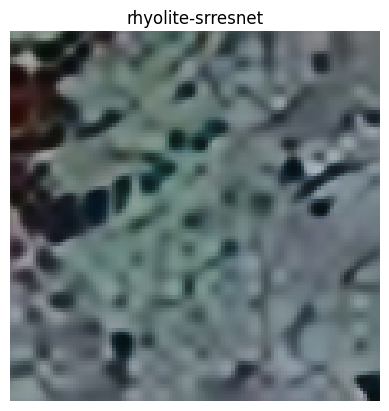

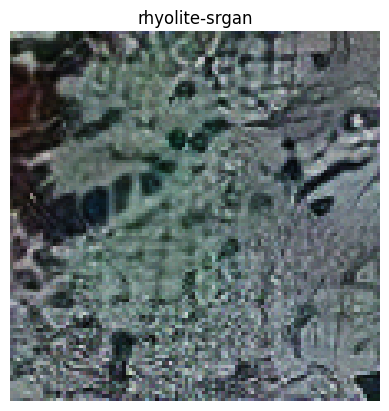

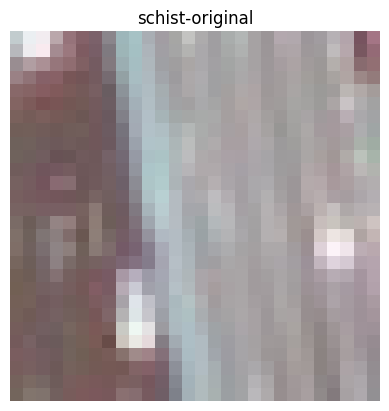

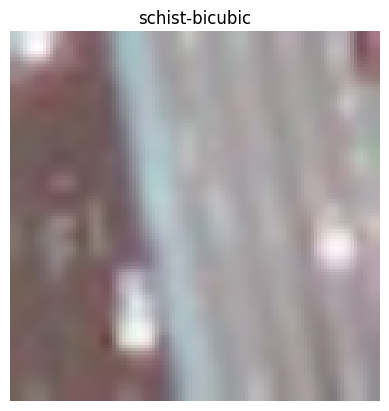

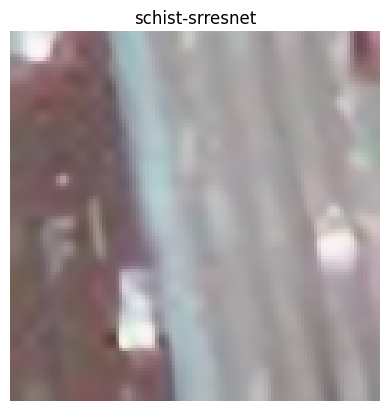

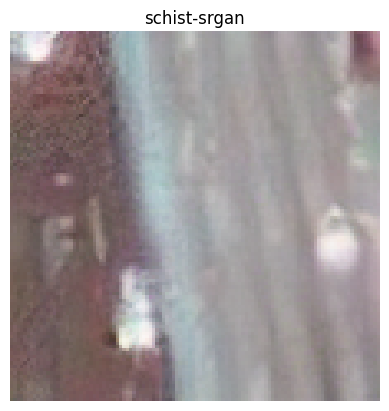

In [10]:
# showcase an example of each class
# use some basic upsampling for visualization purposes
image_dict = {}

for c in classes:
    # read in image from file
    dirpath = os.path.join(GEO_DATA_DIR, c)
    sample_path = os.path.join(dirpath, os.listdir(dirpath)[random.randint(0, len(os.listdir(dirpath)))])
    print(sample_path)
    lr_img, bicubic_img, sr_img_srresnet, sr_img_srgan = test_super_res(sample_path)
    print(f'\tSuper Res Dimensions: {sr_img_srgan.size}')
    plot_data = [(f'{c}-original', lr_img), 
                 (f'{c}-bicubic', bicubic_img), 
                 (f'{c}-srresnet', sr_img_srresnet), 
                 (f'{c}-srgan', sr_img_srgan)]
    for title, img in plot_data:
        plt.figure()
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')


- Resolution quality is a bit better, though GAN seems to have smoothed the edges and provide more distinctive features, so may prefer to use SRGAN instead of SRResnet
- [Future Work] May be worth training a custom low res -> high res model for these specific geo images
- (112, 112) dim should be a large enough dimension to work with for encoding image into image embeddings for vector similarity search

# Is it Possible to Train a Simple, Performant Image Classifcation on this Data? 
- Should help determine how useful our reduced dimensionality vector similarity search engine will be
- Especially when it comes to distinction of features across classes and similarity of features within each class
- Q: Will super resolution improve the models performance?

## Train, Val, Test Split
- Can be used for classification as well as image embedding model

In [11]:
# Train, Val, Test Split - Original Res
random.seed(10)

data = []
for c in classes:
    for root, dirs, files in os.walk(os.path.join(GEO_DATA_DIR, c)):
        for file in files:
            fpath = os.path.join(root, file)
            img = Image.open(fpath).convert('RGB')
            tensor = FT.to_tensor(img)
            (m1, m2, m3) = torch.mean(tensor, dim=[1,2])
            (s1, s2, s3) = torch.std(tensor, dim=[1,2])
            channel, h, w = tuple(tensor.shape)
            data.append({
                'class': c, 
                'file': file, 
                'file_path': fpath, 
                'channels': channel, 
                'height': h, 
                'width': w, 
                'mean': (m1.item(), m2.item(), m3.item()), 
                'std': (s1.item(), s2.item(), s3.item()) 
            })

df = pd.DataFrame(data)
df['train'] = 0
df['val'] = 0
df['test'] = 0

# shuffle and split across classes for balancing purposes
# 60:20:20 train:val:test
train, val ,test = [], [], []
for c in classes:
    file_paths = df[df['class'].eq(c)]['file_path'].to_list()
    random.shuffle(file_paths)
    N = len(file_paths)
    train_idx = round(N*0.6)
    val_idx = train_idx + round(N*0.2)
    test_idx = val_idx + round(N*0.2)
    if test_idx > N: test_idx = N
    # split
    train.extend(file_paths[:train_idx])
    val.extend(file_paths[train_idx:val_idx])
    test.extend(file_paths[val_idx:test_idx])

train = {f: None for f in train}
val = {f: None for f in val}
test = {f: None for f in test}

# Update df
for i, row in df.iterrows():
    fpath = row['file_path']
    if fpath in train: df.at[i, 'train'] = 1
    elif fpath in val: df.at[i, 'val'] = 1
    elif fpath in test: df.at[i, 'test'] = 1


train_count = df['train'].value_counts()[1]
val_count = df['val'].value_counts()[1]
test_count = df['test'].value_counts()[1]

print(f"Total Samples: {len(df.index)}")
print(train_count, val_count, test_count)
assert len(df.index) == train_count + val_count + test_count

print(f"\nTRAIN\n{df[df['train'].eq(1)]['class'].value_counts()}\n")
print(f"VALIDATION\n{df[df['val'].eq(1)]['class'].value_counts()}\n")
print(f"TEST\n{df[df['test'].eq(1)]['class'].value_counts()}\n")

# save df split
df.to_csv(os.path.join(DATA_DIR, 'train_val_test_splits', 'data_split-original.csv'), index=False)
df


Total Samples: 29998
17999 6000 5999

TRAIN
class
andesite     3000
gneiss       3000
quartzite    3000
rhyolite     3000
schist       3000
marble       2999
Name: count, dtype: int64

VALIDATION
class
andesite     1000
gneiss       1000
marble       1000
quartzite    1000
rhyolite     1000
schist       1000
Name: count, dtype: int64

TEST
class
andesite     1000
gneiss       1000
quartzite    1000
rhyolite     1000
schist       1000
marble        999
Name: count, dtype: int64



,class,file,file_path,channels,height,width,mean,std,train,val,test
0,andesite,RAD1H.jpg,/home/jaero/interviews/aws/vector_search/data/...,3,28,28,"(0.42436978220939636, 0.48941075801849365, 0.5...","(0.029418524354696274, 0.027049006894230843, 0...",1,0,0
1,andesite,L6POO.jpg,/home/jaero/interviews/aws/vector_search/data/...,3,28,28,"(0.4495948553085327, 0.4959734380245209, 0.499...","(0.10341965407133102, 0.08796640485525131, 0.0...",1,0,0
2,andesite,1W93C.jpg,/home/jaero/interviews/aws/vector_search/data/...,3,28,28,"(0.29102641344070435, 0.345958411693573, 0.363...","(0.07991520315408707, 0.08474712073802948, 0.0...",0,1,0
3,andesite,J7FX0.jpg,/home/jaero/interviews/aws/vector_search/data/...,3,28,28,"(0.40400660037994385, 0.4794067442417145, 0.47...","(0.03005805052816868, 0.028819747269153595, 0....",0,1,0
4,andesite,1SPCS.jpg,/home/jaero/interviews/aws/vector_search/data/...,3,28,28,"(0.4621448516845703, 0.5291917324066162, 0.545...","(0.02539520338177681, 0.023877235129475594, 0....",1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
29993,schist,CT713.jpg,/home/jaero/interviews/aws/vector_search/data/...,3,28,28,"(0.5667367577552795, 0.6089786887168884, 0.594...","(0.043238382786512375, 0.05675790458917618, 0....",0,1,0
29994,schist,ZETTG.jpg,/home/jaero/interviews/aws/vector_search/data/...,3,28,28,"(0.5196428894996643, 0.5285013914108276, 0.531...","(0.04327203333377838, 0.06677893549203873, 0.0...",1,0,0
29995,schist,1IN00.jpg,/home/jaero/interviews/aws/vector_search/data/...,3,28,28,"(0.7444677352905273, 0.7734593749046326, 0.770...","(0.05652531608939171, 0.10224295407533646, 0.0...",1,0,0
29996,schist,QKFYT.jpg,/home/jaero/interviews/aws/vector_search/data/...,3,28,28,"(0.5737594962120056, 0.6036314368247986, 0.594...","(0.06509469449520111, 0.08209791779518127, 0.0...",1,0,0


In [ ]:
# Train, Val, Test Split - SUPER RES
random.seed(10)

data = []
for c in classes:
    for root, dirs, files in os.walk(os.path.join(GEO_DATA_DIR, c)):
        for file in files:
            fpath = os.path.join(root, file)
            img = Image.open(fpath).convert('RGB')
            img = super_res_transform(img, srgan_generator, device=device)
            new_fpath = fpath.split("/")
            change_idx = None
            for i, comp in enumerate(new_fpath):
                if comp == "geological_similarity": change_idx = i
            if change_idx is None: print(f"ERRROR!!! - {fpath}")
            new_fpath[change_idx] = "geological_similarity_super"
            new_fpath = "/".join(new_fpath)
            img.save(new_fpath)

    print(f"Completed Class: {c}")


In [ ]:
GEO_DATA_DIR_SUPER = os.path.join(DATA_DIR, "geological_similarity_super")

data = []
for c in classes:
    for root, dirs, files in os.walk(os.path.join(GEO_DATA_DIR_SUPER, c)):
        for file in files:
            fpath = os.path.join(root, file)
            img = Image.open(fpath).convert('RGB')
            tensor = FT.to_tensor(img)
            (m1, m2, m3) = torch.mean(tensor, dim=[1,2])
            (s1, s2, s3) = torch.std(tensor, dim=[1,2])
            channel, h, w = tuple(tensor.shape)
            data.append({
                'class': c, 
                'file': file, 
                'file_path': fpath, 
                'channels': channel, 
                'height': h, 
                'width': w, 
                'mean': (m1.item(), m2.item(), m3.item()), 
                'std': (s1.item(), s2.item(), s3.item()) 
            })
    print(f"Completed Class: {c}")

df = pd.DataFrame(data)
df['train'] = 0
df['val'] = 0
df['test'] = 0

# shuffle and split across classes for balancing purposes
# 60:20:20 train:val:test
train, val ,test = [], [], []
for c in classes:
    file_paths = df[df['class'].eq(c)]['file_path'].to_list()
    random.shuffle(file_paths)
    N = len(file_paths)
    train_idx = round(N*0.6)
    val_idx = train_idx + round(N*0.2)
    test_idx = val_idx + round(N*0.2)
    if test_idx > N: test_idx = N
    # split
    train.extend(file_paths[:train_idx])
    val.extend(file_paths[train_idx:val_idx])
    test.extend(file_paths[val_idx:test_idx])

train = {f: None for f in train}
val = {f: None for f in val}
test = {f: None for f in test}

# Update df
for i, row in df.iterrows():
    fpath = row['file_path']
    if fpath in train: df.at[i, 'train'] = 1
    elif fpath in val: df.at[i, 'val'] = 1
    elif fpath in test: df.at[i, 'test'] = 1


train_count = df['train'].value_counts()[1]
val_count = df['val'].value_counts()[1]
test_count = df['test'].value_counts()[1]

print(f"Total Samples: {len(df.index)}")
print(train_count, val_count, test_count)
assert len(df.index) == train_count + val_count + test_count

print(f"\nTRAIN\n{df[df['train'].eq(1)]['class'].value_counts()}\n")
print(f"VALIDATION\n{df[df['val'].eq(1)]['class'].value_counts()}\n")
print(f"TEST\n{df[df['test'].eq(1)]['class'].value_counts()}\n")

# save df split
df.to_csv(os.path.join(DATA_DIR, 'train_val_test_splits', 'data_split-super.csv'), index=False)
df

In [109]:
numeric_labels = {c: i for i, c in enumerate(classes)}

class GeoDataset(Dataset):
    """Dataset for Geo Images

    Args:
        df_data (pd.DataFrame): _description_
        transforms (T.Compose, optional): _description_. Defaults to None.
    """
    def __init__(self, df_data: pd.DataFrame, transforms: T.Compose = None) -> None:
        self.df = df_data
        self.transforms = transforms
    
    def __len__(self):
        return len(self.df.index)
    
    def __getitem__(self, index) -> any:
        row = self.df.iloc[index]
        file_path = row['file_path']
        img = Image.open(file_path).convert('RGB')
        label = row['class']
        label = numeric_labels[label]
        if self.transforms is not None: tensor = self.transforms(img)
        else: tensor = img
        
        return tensor, label, file_path



## DataLoaders & Transforms

In [40]:
def calc_mean_from_tup_list(li):
    idxs = len(ast.literal_eval(li[0]))
    d = {}
    for idx in range(idxs): d[idx] = 0
    for tup in li:
        tup = ast.literal_eval(tup)
        for i, n in enumerate(tup):
            d[i] += n

    for idx in range(idxs): d[idx] = d[idx] / len(li)
    ret = [v for k, v in d.items()]
    return ret

In [94]:
df = pd.read_csv(os.path.join(DATA_DIR, 'train_val_test_splits/data_split-original.csv'))

df_train = df[df['train'].eq(1)]
df_val = df[df['val'].eq(1)]
df_test = df[df['test'].eq(1)]

mean, std = calc_mean_from_tup_list(df['mean'].to_list()), calc_mean_from_tup_list(df['std'].to_list())

transforms = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# create datasets
train = GeoDataset(df_train, transforms=transforms)
val = GeoDataset(df_val, transforms=transforms)
test = GeoDataset(df_test, transforms=transforms)
datasets = {'train': train, 'val': val, 'test': test}

# create dataloaders
# configurable params
batch_size = 10
num_workers = 4

data_loaders = { 
    k: DataLoader(datasets[k], batch_size=batch_size, num_workers=num_workers, shuffle=True) 
    for k in ['train', 'val', 'test']
}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}


## ResNet50 Model

In [95]:

model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(classes))

# freeze pretrained layers
for param in model.parameters(): param.requires_grad = False

# Enable gradient computation for the last few layers
for param in model.layer4.parameters(): param.requires_grad = True

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

summary(model,(3, 112, 112))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 56, 56]          (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 56, 56]          (128)
├─ReLU: 1-3                              [-1, 64, 56, 56]          --
├─MaxPool2d: 1-4                         [-1, 64, 28, 28]          --
├─Sequential: 1-5                        [-1, 256, 28, 28]         --
|    └─Bottleneck: 2-1                   [-1, 256, 28, 28]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 28, 28]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 28, 28]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 28, 28]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 28, 28]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 28, 28]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 28, 28]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 28, 28]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 56, 56]          (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 56, 56]          (128)
├─ReLU: 1-3                              [-1, 64, 56, 56]          --
├─MaxPool2d: 1-4                         [-1, 64, 28, 28]          --
├─Sequential: 1-5                        [-1, 256, 28, 28]         --
|    └─Bottleneck: 2-1                   [-1, 256, 28, 28]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 28, 28]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 28, 28]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 28, 28]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 28, 28]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 28, 28]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 28, 28]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 28, 28]  

## Train Original Resolution ResNet50 Imgae Classification Model

In [96]:
def train_model(
    model, 
    criterion, 
    optimizer, 
    scheduler, 
    data_loaders,
    dataset_sizes,
    num_epochs = 10,
    device = "cpu",
    checkpoint_path = "resnet50_ft.pth" 
):
    start = time.time()
    model = model.to(device)

    best_model_params_path = os.path.join('../saved_models', checkpoint_path)

    torch.save(model.state_dict(), best_model_params_path)
    best_loss = 1e10

    train_stats, val_stats = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train': model.train()
            else: model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels, img_paths) in enumerate(data_loaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train': 
                scheduler.step()
                # get learning rate
                curr_lr = scheduler.get_last_lr()
                print(f"\n----Learning Rate: {curr_lr}----")


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # record train/val epoch loss
            metric_dict = {'epoch': epoch, f'{phase}_loss': epoch_loss}
            if phase == "train": train_stats.append(metric_dict)
            elif phase == "val": val_stats.append(metric_dict)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation Loss: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    df_train_loss = pd.DataFrame(train_stats)
    df_val_loss = pd.DataFrame(val_stats)
    
    df_stats = pd.merge(df_train_loss, df_val_loss, on="epoch")
    return df_stats


Epoch 0/23
----------

----Learning Rate: [0.01]----
train Loss: 0.2396 Acc: 0.9189
val Loss: 0.0811 Acc: 0.9773

Epoch 1/23
----------

----Learning Rate: [0.01]----
train Loss: 0.1082 Acc: 0.9608
val Loss: 0.0742 Acc: 0.9798

Epoch 2/23
----------

----Learning Rate: [0.01]----
train Loss: 0.0855 Acc: 0.9693
val Loss: 0.1302 Acc: 0.9725

Epoch 3/23
----------

----Learning Rate: [0.01]----
train Loss: 0.0721 Acc: 0.9756
val Loss: 0.0792 Acc: 0.9793

Epoch 4/23
----------

----Learning Rate: [0.01]----
train Loss: 0.0690 Acc: 0.9753
val Loss: 0.0988 Acc: 0.9802

Epoch 5/23
----------

----Learning Rate: [0.001]----
train Loss: 0.0650 Acc: 0.9771
val Loss: 0.0528 Acc: 0.9838

Epoch 6/23
----------

----Learning Rate: [0.001]----
train Loss: 0.0357 Acc: 0.9889
val Loss: 0.0605 Acc: 0.9843

Epoch 7/23
----------

----Learning Rate: [0.001]----
train Loss: 0.0283 Acc: 0.9914
val Loss: 0.1269 Acc: 0.9800

Epoch 8/23
----------

----Learning Rate: [0.001]----
train Loss: 0.0225 Acc: 0.9926


<Axes: >

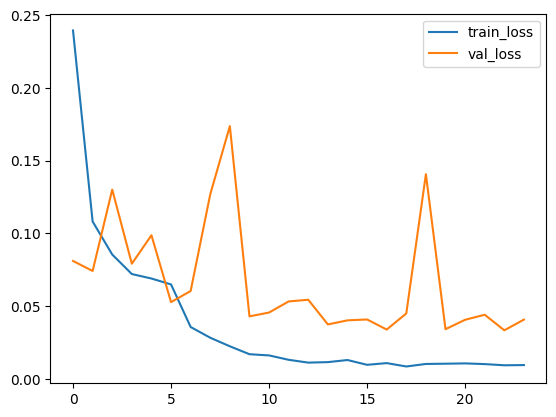

In [97]:
df_stats = train_model(
    model, 
    criterion, 
    optimizer, 
    exp_lr_scheduler, 
    data_loaders,
    dataset_sizes,
    device = device,
    num_epochs = 24,
    checkpoint_path = "resnet50_ft-original.pth" 
)
df_stats[['train_loss', 'val_loss']].plot()

## Train Super Resolution ResNet50 Image Classifcation Model

In [107]:
### DATA INIT
df = pd.read_csv(os.path.join(DATA_DIR, 'train_val_test_splits/data_split-super.csv'))

df_train = df[df['train'].eq(1)]
df_val = df[df['val'].eq(1)]
df_test = df[df['test'].eq(1)]

mean, std = calc_mean_from_tup_list(df['mean'].to_list()), calc_mean_from_tup_list(df['std'].to_list())

transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# create datasets
train = GeoDataset(df_train, transforms=transforms)
val = GeoDataset(df_val, transforms=transforms)
test = GeoDataset(df_test, transforms=transforms)
datasets = {'train': train, 'val': val, 'test': test}

# create dataloaders
# configurable params
batch_size = 10
num_workers = 4

data_loaders = { 
    k: DataLoader(datasets[k], batch_size=batch_size, num_workers=num_workers, shuffle=True) 
    for k in ['train', 'val', 'test']
}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}

### MODEL INIT
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(classes))

# freeze pretrained layers
for param in model.parameters(): param.requires_grad = False

# Enable gradient computation for the last few layers
for param in model.layer4.parameters(): param.requires_grad = True

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.1)

Epoch 0/47
----------

----Learning Rate: [0.01]----
train Loss: 0.2442 Acc: 0.9188
val Loss: 0.6250 Acc: 0.9392

Epoch 1/47
----------

----Learning Rate: [0.01]----
train Loss: 0.1169 Acc: 0.9574
val Loss: 0.1231 Acc: 0.9750

Epoch 2/47
----------

----Learning Rate: [0.01]----
train Loss: 0.0945 Acc: 0.9672
val Loss: 0.2397 Acc: 0.9777

Epoch 3/47
----------

----Learning Rate: [0.01]----
train Loss: 0.0871 Acc: 0.9703
val Loss: 0.0719 Acc: 0.9802

Epoch 4/47
----------

----Learning Rate: [0.01]----
train Loss: 0.0747 Acc: 0.9732
val Loss: 0.2239 Acc: 0.9652

Epoch 5/47
----------

----Learning Rate: [0.01]----
train Loss: 0.0696 Acc: 0.9758
val Loss: 0.7789 Acc: 0.9705

Epoch 6/47
----------

----Learning Rate: [0.01]----
train Loss: 0.0689 Acc: 0.9764
val Loss: 0.5172 Acc: 0.9610

Epoch 7/47
----------

----Learning Rate: [0.01]----
train Loss: 0.0604 Acc: 0.9786
val Loss: 0.2332 Acc: 0.9755

Epoch 8/47
----------

----Learning Rate: [0.01]----
train Loss: 0.0597 Acc: 0.9797
val 

<Axes: >

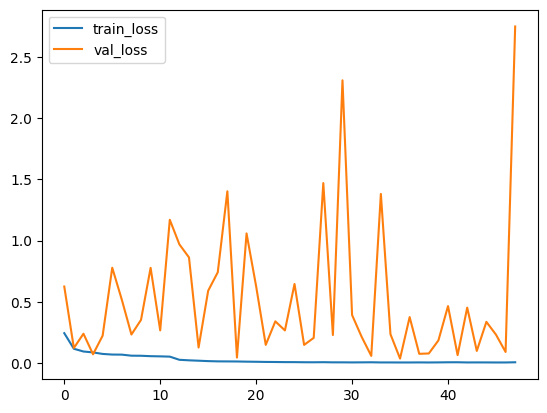

In [108]:
df_stats = train_model(
    model, 
    criterion, 
    optimizer, 
    exp_lr_scheduler, 
    data_loaders,
    dataset_sizes,
    device = device,
    num_epochs = 48,
    checkpoint_path = "resnet50_ft-super.pth" 
)
df_stats[['train_loss', 'val_loss']].plot()

## ResNet50 Model Evaluation

In [110]:
class GeoResNet50Model(nn.Module):
    def __init__(self, *args, n_classes: int = 6, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.model = resnet50()
        self.features = n_classes
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)

    def load_state_dict(self, *args, **kwargs):
        return self.model.load_state_dict(*args, **kwargs)
    
    def forward(self, x):
        return self.model(x)


original_res_checkpoints = "../saved_models/resnet50_ft-original.pth"
super_res_checkpoints = "../saved_models/resnet50_ft-super.pth"

In [111]:
from sklearn.metrics import classification_report

def eval_model(model, data_loader, dataset_size: int):
    model.to(device)

    y_pred, y_true = [], []
    total_correct = 0

    # Iterate over data by batches
    for i, (inputs, labels, img_path) in enumerate(data_loader):
        print(f"{i+1}/{dataset_size}", end="\r")
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        correct = torch.sum(preds == labels.data)
        accuracy = correct.double()
        if accuracy == 1.0: total_correct += 1

        # stats recording
        labels =  labels.detach().cpu().item()
        preds =  preds.detach().cpu().item()
        y_pred.append(preds)
        y_true.append(labels)
    
    total_accuracy = total_correct / dataset_size
    print(f"Test Set Accuracy: {round(total_accuracy, 4)}")
    return y_true, y_pred

In [112]:
# recreate dataset
df = pd.read_csv(os.path.join(DATA_DIR, 'train_val_test_splits/data_split-original.csv'))
mean, std = calc_mean_from_tup_list(df['mean'].to_list()), calc_mean_from_tup_list(df['std'].to_list())
transforms = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

df_test = df[df['test'].eq(1)]
test = GeoDataset(df_test, transforms=transforms)
datasets = {'test': test}
dataset_sizes = {x: len(datasets[x]) for x in ['test']}

## Original Resolution Model Evaluation
model = GeoResNet50Model(n_classes=len(classes))
model.load_state_dict(torch.load(original_res_checkpoints, weights_only=True))
model.eval()

data_loader = DataLoader(datasets['test'], batch_size=1, shuffle=True)
y_true, y_pred = eval_model(model, data_loader, dataset_sizes['test'])

Test Set Accuracy: 0.9903


In [113]:
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

    andesite       0.97      0.99      0.98      1000
      gneiss       1.00      0.99      0.99      1000
      marble       1.00      1.00      1.00       999
   quartzite       0.99      0.98      0.99      1000
    rhyolite       1.00      0.98      0.99      1000
      schist       0.99      1.00      0.99      1000

    accuracy                           0.99      5999
   macro avg       0.99      0.99      0.99      5999
weighted avg       0.99      0.99      0.99      5999



In [114]:
## Super Resolution Model Evaluation
# recreate dataset
df = pd.read_csv(os.path.join(DATA_DIR, 'train_val_test_splits/data_split-super.csv'))
mean, std = calc_mean_from_tup_list(df['mean'].to_list()), calc_mean_from_tup_list(df['std'].to_list())
transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])
df_test = df[df['test'].eq(1)]
test = GeoDataset(df_test, transforms=transforms)
datasets = {'test': test}
dataset_sizes = {x: len(datasets[x]) for x in ['test']}

## Original Resolution Model Evaluation
model = GeoResNet50Model(n_classes=len(classes))
model.load_state_dict(torch.load(super_res_checkpoints, weights_only=True))
model.eval()

data_loader = DataLoader(datasets['test'], batch_size=1, shuffle=True)
y_true, y_pred = eval_model(model, data_loader, dataset_sizes['test'])

In [ ]:
print(classification_report(y_true, y_pred, target_names=classes))

# Image Similarity Search - Solutioning

- **Step 1:** SuperResolutionModel(OriginalImage (24x24)) --> UsableImage (112x112)
- **Step 2:** ImageEmbeddingModel(UsableImage) -> VectorEmbedding () [requires model training for ImageEmbeddingModel]
- **Step 3:** Create Vector Index for Approximate Nearest Neighbor Search (e.g. FAISS, ANNOY) 
- **Step 3a:** (Optional) Utilize a Vector Database (e.g. PineconeDB) to store image embeddings
- **Step 4:** Build and Deploy Containerized Web Application for users to be able to upload image of their choice and return Top K similar images
- **Step 4a:** Top K+N similar vector candidates returned using direct similarity metric calculation (e.g. cosine similarity) where N is tunable depending on computational vs accuracy performance balance
- **Step 4b:** (Optional) Similar vector candidates are then re-ranked according to similarity based on original resolution of images instead in order to account for potential information loss when encoding images into smaller vector representations
- **Step 4c:** Top K similar images are presented to the user based on the input image they uploaded

# Image Embedding Model

In [106]:
class ResNet50EmbeddingModel(nn.Module):
    def __init__(self, *args, num_classes: int = 6, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.model = resnet50()
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def load_state_dict(self, *args, **kwargs):
        self.model.load_state_dict(*args, **kwargs)
        self.model.fc = nn.Identity()
        return self.model
    
    def forward(self, x):
        return self.model(x)


original_res_checkpoints = "../saved_models/resnet50_ft-original.pth"
super_res_checkpoints = "../saved_models/resnet50_ft-super.pth"

model = ResNet50EmbeddingModel(num_classes=len(classes))
model.load_state_dict(torch.load(original_res_checkpoints, weights_only=True))
summary(model, (3, 112, 112))


Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 2048]                --
|    └─Conv2d: 2-1                       [-1, 64, 56, 56]          9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 56, 56]          128
|    └─ReLU: 2-3                         [-1, 64, 56, 56]          --
|    └─MaxPool2d: 2-4                    [-1, 64, 28, 28]          --
|    └─Sequential: 2-5                   [-1, 256, 28, 28]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 28, 28]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 28, 28]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 28, 28]         70,400
|    └─Sequential: 2-6                   [-1, 512, 14, 14]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 14, 14]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 14, 14]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 14, 14] 

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 2048]                --
|    └─Conv2d: 2-1                       [-1, 64, 56, 56]          9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 56, 56]          128
|    └─ReLU: 2-3                         [-1, 64, 56, 56]          --
|    └─MaxPool2d: 2-4                    [-1, 64, 28, 28]          --
|    └─Sequential: 2-5                   [-1, 256, 28, 28]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 28, 28]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 28, 28]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 28, 28]         70,400
|    └─Sequential: 2-6                   [-1, 512, 14, 14]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 14, 14]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 14, 14]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 14, 14] 

## T-SNE Comparison of Embeddings
1. original images flattened
2. resnet50 embedded image vector at original resolution(28 x 28)
3. resnet50 embedded image vector at super resolution (112 x 112)


In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

sample_size = 10

# store embeddings
flattened = []
resnet_original = []
resnet_super = []
total_labels = []

# resnet50 traineed on original resolution (28x28)
res_model_og = ResNet50EmbeddingModel(num_classes=len(classes))
res_model_og.load_state_dict(torch.load(original_res_checkpoints, weights_only=True))

# resnet50 trained on super resolution (112x112)
res_model_super = ResNet50EmbeddingModel(num_classes=len(classes))
res_model_super.load_state_dict(torch.load(super_res_checkpoints, weights_only=True))

# move to device
res_model_og.to(device)
res_model_super.to(device)

# recreate test dataset for original resolution 
df = pd.read_csv(os.path.join(DATA_DIR, 'train_val_test_splits/data_split-original.csv'))
mean_og, std_og = calc_mean_from_tup_list(df['mean'].to_list()), calc_mean_from_tup_list(df['std'].to_list())

df = pd.read_csv(os.path.join(DATA_DIR, 'train_val_test_splits/data_split-super.csv'))
mean_super, std_super = calc_mean_from_tup_list(df['mean'].to_list()), calc_mean_from_tup_list(df['std'].to_list())

transforms = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

df_test = df[df['test'].eq(1)]
test = GeoDataset(df_test, transforms=transforms)
datasets = {'test': test}
dataset_sizes = {x: len(datasets[x]) for x in ['test']}
data_loader = DataLoader(datasets['test'], batch_size=1, shuffle=True)

# note: batch size here is set to 1
for i, (inputs, labels, img_paths) in enumerate(data_loader):
    if i >= sample_size -1: break
    label = labels[0]
    print(f"{i+1}/{dataset_sizes['test']}", end="\r")

    FT.Resize(112)
    FT.to_tensor(inputs)
    FT.normalize()

    # forward
    og_outputs = res_model_og(inputs.to(device))
    super_outputs = res_model_super(inputs.to(device))

    # after forward => (1, 2048)
    og_outputs = og_outputs.detach().cpu().numpy()
    super_outputs = super_outputs.detach().cpu().numpy()

    # flattened
    img = Image.open(img_paths[0]).convert('RGB')
    arr = Image.fromarray(img)
    arr.reshape((1, 28*28*3))

    # store for t-sne
    total_labels.append(label)
    flattened.append(arr)
    resnet_original.append(og_outputs)
    resnet_super.append(super_outputs)



# concat to single numpy array
flattened = np.concatentate(flattened, axis=0)
resnet_original = np.concatentate(resnet_original, axis=0)
resnet_super = np.concatentate(resnet_super, axis=0)
total_labels = np.array(total_labels)


def create_tsne_plot(X, Y, n_components=2):
    n_components = 2
    tsne = TSNE(n_components)
    tsne_result = tsne.fit_transform(X)
    print(tsne_result.shape)

    tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': Y})
    fig, ax = plt.subplots(1)
    sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
    lim = (tsne_result.min()-5, tsne_result.max()+5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [ ]:
## T-SNE - original images flattened
create_tsne_plot(flattened, total_labels, n_components=2)

In [ ]:
## T-SNE - resnet embedding vector at original resolution
create_tsne_plot(resnet_original, total_labels, n_components=2)

In [ ]:
## T-SNE - resnet embedding vector at super resolution
create_tsne_plot(resnet_super, total_labels, n_components=2)

# Vector Index